In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os

In [2]:
path_folder = ""

In [3]:
path_folder_traffic_landuse_street_segment_data= path_folder + "../data/temp/traffic_landuse_street_segment_data.csv"

In [4]:
traffic_landuse_street_segment_data_orig = pd.read_csv(path_folder_traffic_landuse_street_segment_data)

In [5]:
traffic_landuse_street_segment_data_orig["Traffic"] = zscore(
    traffic_landuse_street_segment_data_orig["Traffic"].apply(np.log1p))

* In this training script, 3 different versions of a prediction model will be trained:
  * A Regression Model that uses hour, landuse, number_tra, streetwidt, and is_weekend.
  * 2 Classification Models that omits streetwidt, and is_weekend.
    * A Decision Tree Classification for 3 categories (High, Medium, Low)
    * A Logistic Regression for 2 categories (High, Low)

In [6]:
categ_column_names = ['Hour']
numer_column_names = ['LandUse_01', 'LandUse_02', 'LandUse_03', 'LandUse_04', 'LandUse_05', 'LandUse_06', 
         'LandUse_07', 'LandUse_08', 'LandUse_09', 'LandUse_10', 'LandUse_11', 'LandUse_NULL']
numer_lognorm_column_names = []
numer_lognorm_column_names += ['Number_Tra'] # 83
numer_lognorm_column_names += ['StreetWidt'] # 87
numer_column_names += ['is_weekend'] # 90

MODEL_INPUT_DF_INPUT_COLUMN_NAME = "Traffic"
MODEL_INPUT_DF_INPUT_COLUMN_NAMES = categ_column_names + numer_column_names + numer_lognorm_column_names

categ_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant")),
    ("one-hot", OneHotEncoder(sparse=True,handle_unknown="ignore")),
])

numer_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value=0))
])

transformer = FunctionTransformer(np.log1p)
numer_lognorm_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("log1p", transformer),
    ("normal", StandardScaler())
]
)

ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_column_names),
    ("numer",numer_columns_pipeline,numer_column_names),
    ("numer_lognorm",numer_lognorm_columns_pipeline,numer_lognorm_column_names)
])


Score: 0.9062588022214224


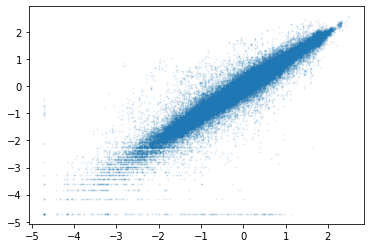

In [7]:
MODEL = LinearRegression()
MODEL = DecisionTreeRegressor()

pl_model = Pipeline([
        ("features", ct0),
        ("model", MODEL)
])

y = traffic_landuse_street_segment_data_orig[MODEL_INPUT_DF_INPUT_COLUMN_NAME]#>0
X = traffic_landuse_street_segment_data_orig[MODEL_INPUT_DF_INPUT_COLUMN_NAMES]

X_train, X_test, y_train, y_test = train_test_split(X,y)
np.random.seed(1)
pl_model.fit(X_train, y_train)
np.random.seed(1)
#print("Cross val score:", cross_val_score(pl_model, X_train, y_train, cv=4))
print("Score:", pl_model.score(X_test, y_test))
plt.scatter(pl_model.predict(X_test), y_test, s=1, alpha=0.1)

In [8]:
with open(path_folder +'../data/final/dtr.pkl', 'wb') as f:
    pickle.dump(pl_model, f)
    f.close()

In [9]:
def categorical_metrics(model, category_amount):
    #importing accuracy_score, precision_score, recall_score, f1_score
    y_preds = model.predict(X_test)

    # precision : TP/(TP+FP), or correctness % of given category claims
    # recall/sensitivity: TP/(TP+FN), or correctness % of actual given category
    # Specificity: TN/(TN+FP) or anti of correctness % of actual given category
    # F1: 2*((Prec*Recall)/(Prec+Recall))
    # Type1, Type2 Errors


    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_preds)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_preds, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_preds, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_preds, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_preds, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_preds, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_preds, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_preds, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_preds, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_preds, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_preds, target_names=(np.arange(category_amount)).astype(str)))


    confusionMatrix = confusion_matrix(y_preds, y_test)

    confusionMatrix_normalized = confusionMatrix / confusionMatrix.sum(axis=1,keepdims=True)
    fig, ax = plt.subplots(figsize=(10,10)) 

    ax = sns.heatmap(confusionMatrix_normalized, annot=True) #notation: "annot" not "annote"
    y_lims = ax.get_ylim()

    ax.set_ylim(sum(y_lims), 0)

In [10]:
categ_column_names = ['Hour']
numer_column_names = ['LandUse_01', 'LandUse_02', 'LandUse_03', 'LandUse_04', 'LandUse_05', 'LandUse_06', 
         'LandUse_07', 'LandUse_08', 'LandUse_09', 'LandUse_10', 'LandUse_11', 'LandUse_NULL']
numer_lognorm_column_names = ["Number_Tra"]
# numer_lognorm_column_names += ['is_weekend'] # 83
# numer_lognorm_column_names += ['StreetWidt'] # 87
ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_column_names),
    ("numer",numer_columns_pipeline,numer_column_names),
    ("numer_lognorm",numer_lognorm_columns_pipeline,numer_lognorm_column_names)
])
MODEL_INPUT_DF_OUTPUT_COLUMN_NAME = "Traffic"
MODEL_INPUT_DF_INPUT_COLUMN_NAMES = categ_column_names + numer_column_names + numer_lognorm_column_names

Score: 0.8484909922956613

Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.77
Macro Recall: 0.90
Macro F1-score: 0.82

Weighted Precision: 0.89
Weighted Recall: 0.85
Weighted F1-score: 0.85

Classification Report

              precision    recall  f1-score   support

           0       0.67      0.96      0.79     14206
           1       0.67      0.93      0.78     15983
           2       0.98      0.81      0.88     73389

    accuracy                           0.85    103578
   macro avg       0.77      0.90      0.82    103578
weighted avg       0.89      0.85      0.85    103578



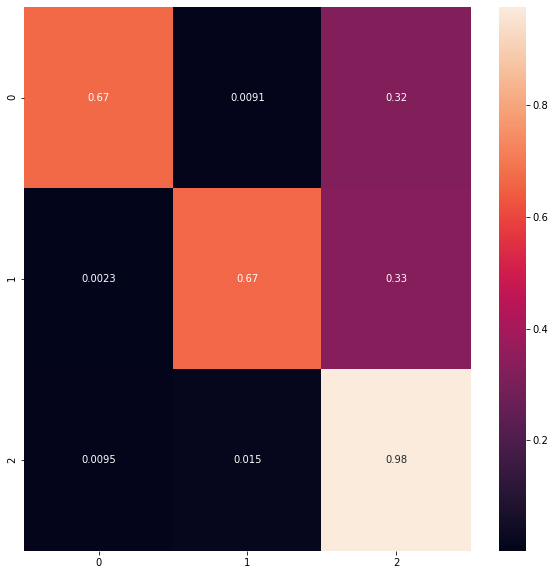

In [11]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#MODEL = LinearDiscriminantAnalysis()
MODEL = DecisionTreeClassifier(class_weight="balanced")
#MODEL = LogisticRegression(multi_class='multinomial',solver ='newton-cg')

def tri_level(x): 
    if x <-1: level="LOW";
    elif x >= -1 and x < 1: level="MEDIUM";
    else: level = "HIGH";
    return level

y = pd.Series(zscore(traffic_landuse_street_segment_data_orig[MODEL_INPUT_DF_OUTPUT_COLUMN_NAME], axis=0)).apply(tri_level)
X = traffic_landuse_street_segment_data_orig[MODEL_INPUT_DF_INPUT_COLUMN_NAMES]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

seed_i = 1
np.random.seed(seed_i)

numer_lognorm_columns = []
pl_model = Pipeline([
        ("features", ct0),
        ("model", MODEL)
])
np.random.seed(seed_i)
pl_model.fit(X_train, y_train)
np.random.seed(seed_i)
#print("Cross val score:", cross_val_score(pl_model, X_train, y_train, cv=4))
print("Score:", pl_model.score(X_test, y_test))

with open(path_folder +'../data/final/dtc.pkl', 'wb') as f:
    pickle.dump(pl_model, f)
    f.close()

categorical_metrics(pl_model, 3)

Score: 0.7946764756994729

Accuracy: 0.79

Micro Precision: 0.79
Micro Recall: 0.79
Micro F1-score: 0.79

Macro Precision: 0.79
Macro Recall: 0.79
Macro F1-score: 0.79

Weighted Precision: 0.79
Weighted Recall: 0.79
Weighted F1-score: 0.79

Classification Report

              precision    recall  f1-score   support

           0       0.79      0.74      0.76     46125
           1       0.80      0.84      0.82     57453

    accuracy                           0.79    103578
   macro avg       0.79      0.79      0.79    103578
weighted avg       0.79      0.79      0.79    103578



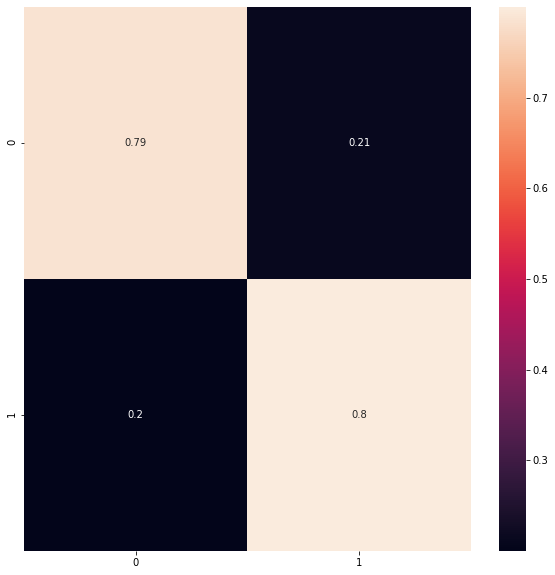

In [12]:
y = zscore(traffic_landuse_street_segment_data_orig[MODEL_INPUT_DF_OUTPUT_COLUMN_NAME], axis=0) > 0
X = traffic_landuse_street_segment_data_orig[MODEL_INPUT_DF_INPUT_COLUMN_NAMES]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

MODEL = LogisticRegression(max_iter=500)

pl_model = Pipeline([
        ("features", ct0),
        ("model", MODEL)
])
np.random.seed(seed_i)
pl_model.fit(X_train, y_train)
np.random.seed(seed_i)
#print("Cross val score:", cross_val_score(pl_model, X_train, y_train, cv=4))
print("Score:", pl_model.score(X_test, y_test))

with open(path_folder +'../data/final/logreg.pkl', 'wb') as f:
    pickle.dump(pl_model, f)
    f.close()

categorical_metrics(pl_model, 2)